In [ ]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive')

!pip install -qU catboost eif shap category_encoders optuna
clear_output()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, roc_curve

from sklearn.base import BaseEstimator, TransformerMixin

from tqdm.notebook import tqdm
from scipy import stats
from scipy.stats import mannwhitneyu, shapiro
from scipy.stats import chi2_contingency
import statsmodels.stats.power as power
from itertools import combinations

from catboost import Pool, CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm
import shap
import optuna
from optuna.samplers import TPESampler

np.random.seed(123)

In [ ]:
train_path = '/content/drive/My Drive/data/churn_median/train.csv'
test_path = '/content/drive/My Drive/data/churn_median/test.csv'
TARGET_NAME = 'Is_Lead'

In [ ]:
train_df = pd.read_csv(train_path)

In [ ]:
train_df.sample(5)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
66674,HGDFMRDO,Male,46,RG251,Self_Employed,X2,80,No,863006,No,0
167206,PFKGSRRE,Male,27,RG281,Self_Employed,X1,15,NaN,1464797,No,1
196396,CJPJZQ7W,Male,37,RG270,Self_Employed,X3,19,No,630235,No,0
92642,DPZH4TT9,Female,42,RG283,Other,X1,80,NaN,274787,Yes,1
229630,DW7XUUFR,Male,51,RG254,Self_Employed,X4,13,No,1102941,No,0


In [ ]:
train_df.Is_Lead.value_counts(normalize=True)
# class imbalance

0    0.762792
1    0.237208
Name: Is_Lead, dtype: float64

In [ ]:
# statistic helper functions

def effect_size(factor_a, factor_b, cohen=True, desired_power=0.8, alpha=0.05):
    n1, n2 = len(factor_a), len(factor_b)
    s1, s2 = factor_a.std(ddof=1), factor_b.std(ddof=1)
    df = (s1 ** 2 / n1 + s2 ** 2 / n2) ** 2 / \
          ((s1 ** 2 / n1) ** 2 / (n1 - 1) + (s2 ** 2 / n2) ** 2 / (n2 - 1))
    if cohen:
        sigma_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
        return np.abs(factor_a.mean() - factor_b.mean()) / sigma_pooled, df
    else:
        return power.tt_ind_solve_power(effect_size=None, nobs1=len(factor_a), alpha=alpha, power=desired_power,
                                        ratio=len(factor_b)/len(factor_a), alternative='two-sided'), df

def statistic_output(*columns, df=train_df, cat=False, target=TARGET_NAME, alpha=0.05, sample_size=0):
    data = df.copy()
    data.drop_duplicates(inplace=True)
    if sample_size == 0:
        sample_size = int(0.05 * len(data))
    if not cat:
        columns = data.drop(target, axis=1).select_dtypes(exclude=['category', np.object]).columns
        for column in columns:
            df_sampled = data[[column, target]].sample(sample_size, random_state=1)
            factor_a = df_sampled.loc[df_sampled[target] == 0][column]   
            factor_b = df_sampled.loc[df_sampled[target] == 1][column]
            var_a, var_b = factor_a.var(), factor_b.var()   
            _, pvalue = stats.shapiro(df_sampled[column])
            if pvalue >= alpha:
                _, pvalue = stats.ttest_ind(factor_a, factor_b, equal_var=False)
                test = power.TTestIndPower()
                eff_size, deg_free = effect_size(factor_a, factor_b, cohen=False)
                pow = test.power(effect_size=eff_size, nobs1=len(factor_a), alpha=alpha, df=deg_free, 
                                 ratio=len(factor_b)/len(factor_a), alternative='two-sided')
            else:
                _, pvalue = stats.mannwhitneyu(factor_a, factor_b)
                pow, eff_size = None, None
            if pvalue < alpha:
                result = f'with effect_size = {eff_size:.4f} and ttest power {pow*100:.2f}%' if pow is not None else ''
                print(f'Factor "{column}" has statistical influence on target (var_a: {var_a:.2f}, var_b: {var_b:.2f}). {result}')
            else:
                print(f'Factor "{column}" does not affect target.')
    else:
        for column in columns:
            print(column)
            categories = data[column].unique().tolist()
            for pair in combinations(categories, r=2):
                a, b = pair
                if a != b:
                    data_ = data.loc[data[column].isin(pair), ['ID', column, target]].sample(sample_size, random_state=1)
                    table = data_.pivot_table(values='ID', index=column, columns=target, aggfunc='count')
                    _, pvalue, _, _ = stats.chi2_contingency(table, correction=False)
                    if pvalue >= alpha:  
                        print(f'Categories {a} and {b} can be united.')
                    else:
                        continue
                        #print(f'Categories {a} and {b} have different frequencies with target.')
            print('-'*30)

def correlation(df: pd.DataFrame, target=TARGET_NAME, alpha=0.05, threshold=0.66, method='pearson'):
    data = df.copy()
    data = data.drop(target, axis=1)
    columns = data.select_dtypes(exclude=['category', np.object]).columns
    for pair in combinations(columns, r=2):
        col1, col2 = pair
        if method == 'pearson':
            r, pvalue = stats.pearsonr(data[col1], data[col2])
        elif method == 'kendall':
            r, pvalue = stats.kendalltau(data[col1], data[col2])
        elif method == 'spearman':
            r, pvalue = stats.spearmanr(data[col1], data[col2])                   
        else:
            raise ValueError(f'Method should be "spearman", "kendall" or "pearson", got: {method}')
        if r >= threshold:    
            if pvalue < alpha:
                print(f'Correlation ({method}) between {col1} and {col2} is statisticaly strong: {r:.4f}.')
            else:
                print(f'Correlation ({method}) between {col1} and {col2} is high but not statisticaly meaningful.')

In [ ]:
# plotting and metric helper functions

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}')
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

def plot_ROC(y_train_true, y_train_prob, y_test_true, y_test_prob):
    '''
    a funciton to plot the ROC curve for train labels and test labels.
    Use the best threshold found in train set to classify items in test set.
    '''
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_true, y_train_prob, pos_label=True)
    sum_sensitivity_specificity_train = tpr_train + (1-fpr_train)
    best_threshold_id_train = np.argmax(sum_sensitivity_specificity_train)
    best_threshold = thresholds_train[best_threshold_id_train]
    best_fpr_train = fpr_train[best_threshold_id_train]
    best_tpr_train = tpr_train[best_threshold_id_train]
    y_train = y_train_prob > best_threshold

    cm_train = confusion_matrix(y_train_true, y_train)
    acc_train = accuracy_score(y_train_true, y_train)
    auc_train = roc_auc_score(y_train_true, y_train)

    print('Train Accuracy: %s ' %acc_train)
    print('Train AUC: %s ' %auc_train)
    print('Train Confusion Matrix:')
    print(cm_train)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    curve1 = ax.plot(fpr_train, tpr_train)
    curve2 = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax.plot(best_fpr_train, best_tpr_train, marker='o', color='black')
    ax.text(best_fpr_train, best_tpr_train, s = '(%.3f,%.3f)' %(best_fpr_train, best_tpr_train))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Train), AUC = %.4f'%auc_train)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test_true, y_test_prob, pos_label =True)

    y_test = y_test_prob > best_threshold

    cm_test = confusion_matrix(y_test_true, y_test)
    acc_test = accuracy_score(y_test_true, y_test)
    auc_test = roc_auc_score(y_test_true, y_test)

    print('Test Accuracy: %s ' %acc_test)
    print('Test AUC: %s ' %auc_test)
    print('Test Confusion Matrix:')
    print(cm_test)

    tpr_score = float(cm_test[1][1])/(cm_test[1][1] + cm_test[1][0])
    fpr_score = float(cm_test[0][1])/(cm_test[0][0]+ cm_test[0][1])

    ax2 = fig.add_subplot(122)
    curve1 = ax2.plot(fpr_test, tpr_test)
    curve2 = ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax2.plot(fpr_score, tpr_score, marker='o', color='black')
    ax2.text(fpr_score, tpr_score, s = '(%.3f,%.3f)' %(fpr_score, tpr_score))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Test), AUC = %.4f'%auc_test)
    plt.savefig('ROC', dpi = 500)
    plt.show()

    return best_threshold

In [ ]:
train_df.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [ ]:
train_df.describe(include=[np.object])

# inspect cardinality of categorical features

,ID,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
count,245725,245725,245725,245725,245725,216400,245725
unique,245725,2,35,4,4,2,2
top,NNVBBKZB,Male,RG268,Self_Employed,X1,No,No
freq,1,134197,35934,100886,103718,144357,150290


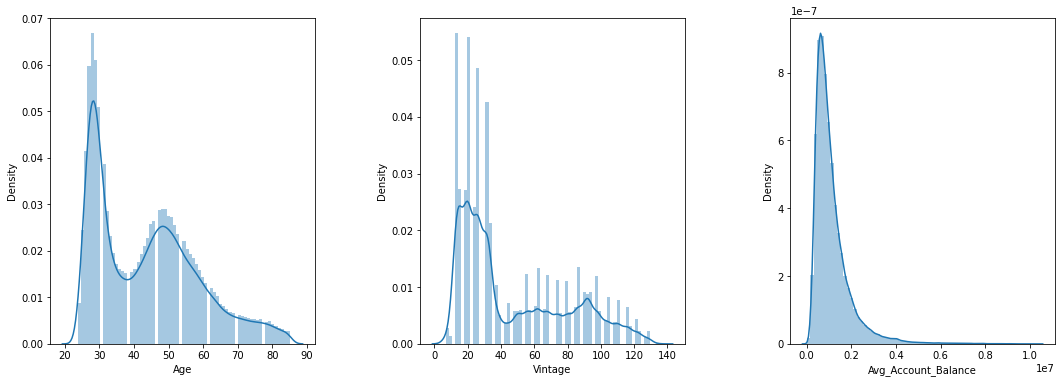

In [ ]:
plt.figure(figsize=(18, 6))
numeric_cols = train_df.select_dtypes(['float', 'int']).columns[:-1]
for idx, col in enumerate(numeric_cols):
    plt.subplot(1, 3, idx + 1)
    sns.distplot(train_df[col], bins=70)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
# Avg_Account_Balance have log_normal distribution?

In [ ]:
cat_columns = train_df.select_dtypes(include=['object']).columns[1:].tolist()
cat_columns = [column for column in cat_columns if column not in ['Region_Code'] and train_df[column].nunique()>2]
stat_df = train_df.fillna('unk')
statistic_output(*cat_columns, df=stat_df, cat=True)
del stat_df
# thus, having sample of 5% from general population we have no categories to unite (except Region_Code),
# which we are going to target-encode

Occupation
------------------------------
Channel_Code
------------------------------


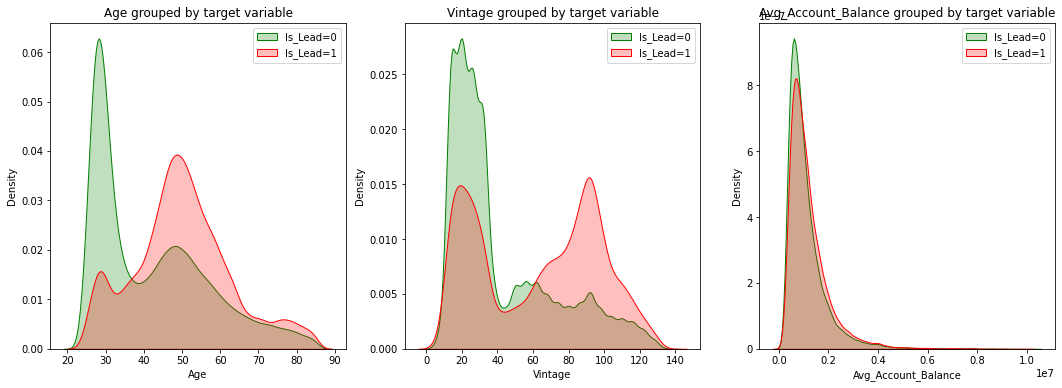

In [ ]:
# distributions of numerical features through target values

plt.figure(figsize=(18, 6))
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, idx)
    feature_with_target_s = train_df[[col, TARGET_NAME]]
    feature_s = feature_with_target_s[col]
    feature_target_0 = feature_s[feature_with_target_s[TARGET_NAME] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET_NAME] == 1]

    sns.kdeplot(feature_target_0, shade=True, label='Is_Lead=0', color='g')
    sns.kdeplot(feature_target_1, shade=True, label='Is_Lead=1', color='r')
    plt.xlabel(col)
    plt.title(f'{col} grouped by target variable')
    plt.legend(loc='best')
plt.show()
# Age, Vintage, Avg_Account_Balance have different impact on target

In [ ]:
statistic_output(*cat_columns)
# the results of previous plot proved by statistic tests

Factor "Age" has statistical influence on target (var_a: 227.29, var_b: 171.16). 
Factor "Vintage" has statistical influence on target (var_a: 913.75, var_b: 1180.19). 
Factor "Avg_Account_Balance" has statistical influence on target (var_a: 702951150573.77, var_b: 756495914609.90). 


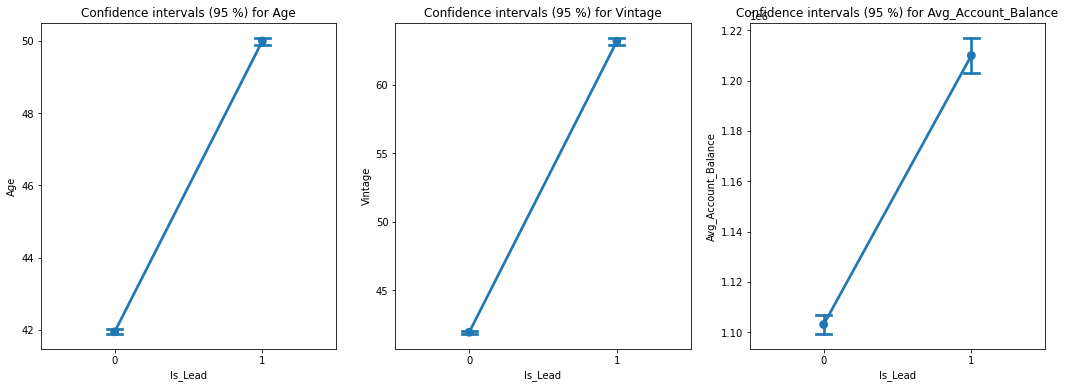

In [ ]:
plt.figure(figsize=(18, 6))
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, idx)
    to_plot = train_df[[col, TARGET_NAME]]
    sns.pointplot(x=TARGET_NAME, y=col, data=to_plot, capsize=.1)
    plt.title(f'Confidence intervals (95 %) for {col}')
plt.show()

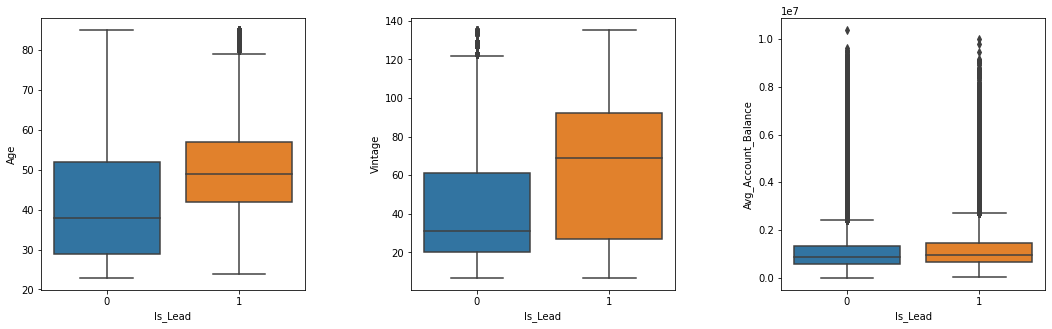

In [ ]:
plt.figure(figsize=(18, 12))
numeric_cols = train_df.select_dtypes(['float', 'int']).columns[:-1]
for idx, col in enumerate(numeric_cols):
    plt.subplot(2, 3, idx + 1)
    sns.boxplot(x=TARGET_NAME, y=col, data=train_df)
    plt.ylabel(col)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
# visual check for outliers
# there are some possible outliers, but we are not going to remove or replace them, as they are not extreme

In [ ]:
correlation(train_df, threshold=0.33)
# pretty high correlation between Age and Vintage, but not enough to drop one of them(we don't have many features)

Correlation (pearson) between Age and Vintage is statisticaly strong: 0.6312.


In [ ]:
train_df = pd.read_csv(train_path)  # reload the dataset
train_df.set_index('ID', drop=True, inplace=True)  # set ID to index to remove this feature and use it in preds
train_df.fillna('NAN', inplace=True)  # or do the same by SimpleImputer in pipeline
train_df.drop_duplicates(inplace=True)  # remove duplicates
train_df = reduce_memory(train_df)  # optimize memory usage

X, y = train_df.drop(TARGET_NAME, axis=1), train_df[TARGET_NAME]
# make train/valid/test splits
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.35, shuffle=True, stratify=y, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.3, shuffle=True, stratify=y_valid, random_state=123)
X_train.shape, X_valid.shape, X_test.shape

Memory usage of dataframe is 20.62 MB
Memory usage after optimization is: 5.16 MB
Decreased by 75.0%


((159707, 9), (60197, 9), (25800, 9))

In [ ]:
# base CatBoost model on raw data
cat_columns = X.select_dtypes(include=['category']).columns.tolist()  # define categorical columns
train_pool = Pool(X_train, y_train, cat_features=cat_columns)  # define train pool
valid_pool = Pool(X_valid, y_valid, cat_features=cat_columns)  # define valid pool

base = CatBoostClassifier(verbose=0)  # define default model
base.fit(train_pool, eval_set=valid_pool)  # fit model
base_train_pred = base.predict(X_train)
base_test_pred = base.predict(X_test)
base_train_proba = base.predict_proba(X_train)[:,1]
base_test_proba = base.predict_proba(X_test)[:,1]
# display metrics and statistics
report(y_train, base_train_pred, y_test, base_test_pred, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      0.874     0.959     0.914    121834
           1      0.807     0.554     0.657     37887

    accuracy                          0.863    159721
   macro avg      0.840     0.756     0.785    159721
weighted avg      0.858     0.863     0.853    159721

Test
               precision    recall  f1-score   support

           0      0.873     0.956     0.913     19682
           1      0.798     0.554     0.654      6120

    accuracy                          0.861     25802
   macro avg      0.836     0.755     0.783     25802
weighted avg      0.855     0.861     0.851     25802

Train ROC_AUC: 0.879, Test ROC_AUC: 0.876
Confusion Matrix 
 col_0        0     1
Is_Lead             
0        18823   859
1         2731  3389


In [ ]:
class DataFrameR(BaseEstimator, TransformerMixin):
    # class to return pandas dataFrame from input array
    def __init__(self, columns, index=None):
        self.columns = columns
        self.index = index

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert len(self.columns) == X.shape[1], f'Number of columns {len(self.columns)} is not equal to data shape {X.shape[1]}'
        if self.index is not None:
            X_ = pd.DataFrame(X, columns=self.columns, index=self.index)
        else:
            X_ = pd.DataFrame(X, columns=self.columns)
        return X_

class ColumnSelector(BaseEstimator, TransformerMixin):
    # class to select particular columns from input dataFrame
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            return X
        return X[self.columns]

class FeatureCreator(BaseEstimator, TransformerMixin):
    # class that creates new features
    def __init__(self, target=TARGET_NAME):
        self.target = target
        self.agg_age_vint = None
        self.agg_age_vint_median = None
        self.agg_cred_reg = None
        self.agg_cred_reg_median = None

    def fit(self, X, y=None):
        # get grouped Age and Vintage by mean target
        X_ = X.copy()
        X_ = pd.concat([X,y], axis=1)
        self.agg_age_vint = X_.groupby(['Age', 'Vintage'], as_index=False)[self.target].agg('mean')
        self.agg_age_vint.columns = ['Age', 'Vintage', 'AVT']
        self.agg_age_vint_median = self.agg_age_vint.AVT.median()

        # get grouped Credit_Product and Region_Code by target count
        self.agg_cred_reg = X_.groupby(['Credit_Product', 'Region_Code'], as_index=False)[self.target].agg('count')
        self.agg_cred_reg.columns = ['Credit_Product', 'Region_Code', 'TC']
        self.agg_cred_reg_median = self.agg_cred_reg.median()  # .mode()[0] - also possible
        return self

    def transform(self, X):
        X_index = X.index.copy()

        # merge AVT with input dataFrame
        X = X.merge(self.agg_age_vint, on=['Age', 'Vintage'], how='left')
        X.AVT.fillna(self.agg_age_vint_median, inplace=True)
        X.AVT = X.AVT.astype(np.float32)

        # merge TC with input dataFrame
        X = X.merge(self.agg_cred_reg, on=['Credit_Product', 'Region_Code'], how='left')
        X.TC.fillna(self.agg_cred_reg_median, inplace=True)
        X.TC = X.TC.astype(np.int32)

        X.index = X_index
        return X

class FeatureSelector(BaseEstimator, TransformerMixin):
    # class that returns only N best features from input dataFrame based on shap-values
    def __init__(self, N=10, valid_pool=valid_pool):
        self.N = N
        self.valid_pool = valid_pool
        self.selected_columns = None
    
    def fit(self, X, y=None):
        if y is not None:
            X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, shuffle=True, 
                                                                  stratify=y, random_state=123)
            cat_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()
            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            test_pool = Pool(X_valid, y_valid, cat_features=cat_cols)
        else: 
            raise ValueError(f'Set target variable for feature selection')

        summary = self.select_features(train_pool=train_pool, test_pool=test_pool, num_to_select=self.N)
        self.selected_columns = list(summary['selected_features_names'])
        return self

    def transform(self, X):
        return X[self.selected_columns]
    
    @staticmethod
    def select_features(train_pool: Pool,
                        test_pool: Pool,
                        algorithm: EFeaturesSelectionAlgorithm = EFeaturesSelectionAlgorithm.RecursiveByShapValues, 
                        steps: int = 1, 
                        num_to_select: int = 10):
        model = CatBoostClassifier(iterations=100, random_seed=0)
        print('Selecting features')
        summary = model.select_features(
            train_pool,
            eval_set=test_pool,
            features_for_select=list(range(train_pool.num_col())),
            num_features_to_select=num_to_select,
            steps=steps,
            algorithm=algorithm,
            shap_calc_type=EShapCalcType.Regular,
            train_final_model=False,
            logging_level='Silent',
            plot=False
        )
        clear_output()
        return summary

In [ ]:
# add / eliminate new features via pipeline
pipeline = Pipeline(steps=[('Engeneering', FeatureCreator()),
                           ('Selector', FeatureSelector())])
# selector dropped Avg_Account_Balance: looks like it's no matter what account balance you have?
X_train_ = pipeline.fit_transform(X_train, y_train)
X_valid_ = pipeline.transform(X_valid)
X_test_ = pipeline.transform(X_test)

In [ ]:
cat_cols = X_train_.select_dtypes(include=['category', 'object']).columns.tolist()
train_pool = Pool(X_train_, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid_, y_valid, cat_features=cat_cols)

In [ ]:
# constant model parameters
params_model = {
    'eval_metric': 'F1', 
    'iterations': 1000,
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 4,
    'early_stopping_rounds': 20,
    'grow_policy': 'SymmetricTree',
    'allow_writing_files': False,
    'use_best_model': True,
    'random_seed': 123,
    'max_ctr_complexity': 6,
    'combinations_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'], # to increase border between encoded categories
    'simple_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'], 
    }
# in a more detailed search we can provide feature_weights also

In [ ]:
def objective(trial):
    param_forest = {
                    'depth': trial.suggest_int('depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1., 5.),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 1., 3.),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
                    }
    opt_model = CatBoostClassifier(**params_model)
    opt_model.fit(train_pool, eval_set=valid_pool)
    
    y_pred = opt_model.predict(X_valid_)
    score = f1_score(y_valid, y_pred)
    
    return score

In [ ]:
study = optuna.create_study(sampler=TPESampler(seed=123), direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')
# output removed as too free notebook space

In [ ]:
model_params = {
                'depth': 4,  # 7
                'learning_rate': 0.05,  # 0.15020827412568594
                'l2_leaf_reg': 5.5,  # 1.9074058142568124
                'bagging_temperature': 2.1026295381657825,
                'subsample': 0.8597344848927815,
                'colsample_bylevel': 0.7115532300622305,
                'boosting_type': 'Plain',  # Ordered
                'eval_metric': 'F1', 
                'iterations': 1000,
                'auto_class_weights': 'Balanced',
                'silent': True,
                'one_hot_max_size': 4,
                'early_stopping_rounds': 10,  # 20
                'grow_policy': 'SymmetricTree',
                'allow_writing_files': False,
                'use_best_model': True,
                'random_seed': 123,
}

In [ ]:
# take tuned parameters and tune them customly
catboost = CatBoostClassifier(**model_params)
catboost.fit(train_pool, eval_set=valid_pool)

cat_train_pred = catboost.predict(X_train_)
cat_test_pred = catboost.predict(X_test_)
cat_train_proba = catboost.predict_proba(X_train_)[:,1]
cat_test_proba = catboost.predict_proba(X_test_)[:,1]

report(y_train, cat_train_pred, y_test, cat_test_pred, cat_train_proba, cat_test_proba)

Train
               precision    recall  f1-score   support

           0      0.923     0.826     0.872    121820
           1      0.582     0.778     0.666     37887

    accuracy                          0.815    159707
   macro avg      0.752     0.802     0.769    159707
weighted avg      0.842     0.815     0.823    159707

Test
               precision    recall  f1-score   support

           0      0.920     0.821     0.868     19679
           1      0.572     0.770     0.657      6121

    accuracy                          0.809     25800
   macro avg      0.746     0.795     0.762     25800
weighted avg      0.837     0.809     0.818     25800

Train ROC_AUC: 0.874, Test ROC_AUC: 0.863
Confusion Matrix 
 col_0        0     1
Is_Lead             
0        16158  3521
1         1409  4712


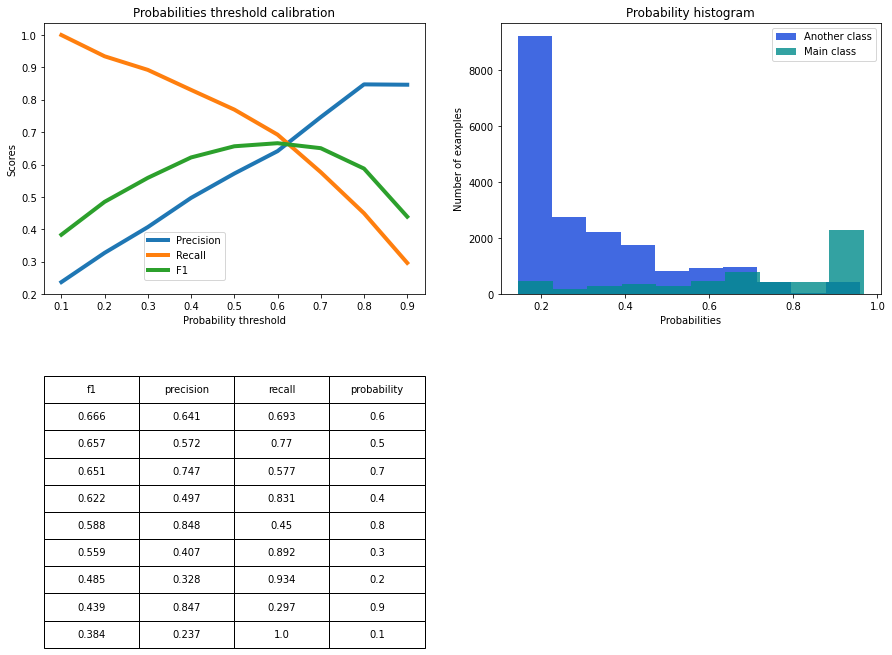

In [ ]:
show_proba_calibration_plots(cat_test_proba, y_test)

In [ ]:
# calibrate F1-score
func = lambda x: x[1] >= 0.6
train_probas = catboost.predict_proba(X_train_)
test_probas = catboost.predict_proba(X_test_)

calib_preds_train = np.apply_along_axis(func, arr=train_probas, axis=1)
calib_preds_test = np.apply_along_axis(func, arr=test_probas, axis=1)
report(y_train, calib_preds_train, y_test, calib_preds_test)

Train
               precision    recall  f1-score   support

           0      0.908     0.886     0.897    121820
           1      0.659     0.711     0.684     37887

    accuracy                          0.844    159707
   macro avg      0.784     0.799     0.791    159707
weighted avg      0.849     0.844     0.846    159707

Test
               precision    recall  f1-score   support

           0      0.902     0.880     0.891     19679
           1      0.641     0.693     0.666      6121

    accuracy                          0.835     25800
   macro avg      0.772     0.786     0.778     25800
weighted avg      0.840     0.835     0.837     25800

Confusion Matrix 
 col_0    False  True
Is_Lead             
0        17310  2369
1         1882  4239


In [ ]:
# let's try to make partial train on valid data
test_pool = Pool(X_test_, y_test, cat_features=cat_cols)
catboost_part = CatBoostClassifier(**model_params)
catboost_part.fit(valid_pool, eval_set=test_pool, init_model=catboost)

cat_train_pred_ = catboost_part.predict(X_train_)
cat_test_pred_ = catboost_part.predict(X_test_)
cat_train_proba_ = catboost_part.predict_proba(X_train_)[:,1]
cat_test_proba_ = catboost_part.predict_proba(X_test_)[:,1]

report(y_train, cat_train_pred_, y_test, cat_test_pred_, cat_train_proba_, cat_test_proba_)

Train
               precision    recall  f1-score   support

           0      0.923     0.828     0.873    121820
           1      0.585     0.778     0.668     37887

    accuracy                          0.816    159707
   macro avg      0.754     0.803     0.770    159707
weighted avg      0.843     0.816     0.824    159707

Test
               precision    recall  f1-score   support

           0      0.920     0.823     0.869     19679
           1      0.575     0.770     0.658      6121

    accuracy                          0.810     25800
   macro avg      0.748     0.797     0.764     25800
weighted avg      0.838     0.810     0.819     25800

Train ROC_AUC: 0.874, Test ROC_AUC: 0.864
Confusion Matrix 
 col_0        0     1
Is_Lead             
0        16195  3484
1         1407  4714


Train Accuracy: 0.8245975442529131 
Train AUC: 0.8043068870253891 
Train Confusion Matrix:
[[102684  19136]
 [  8877  29010]]
Test Accuracy: 0.818217054263566 
Test AUC: 0.7973768645309746 
Test Confusion Matrix:
[[16472  3207]
 [ 1483  4638]]


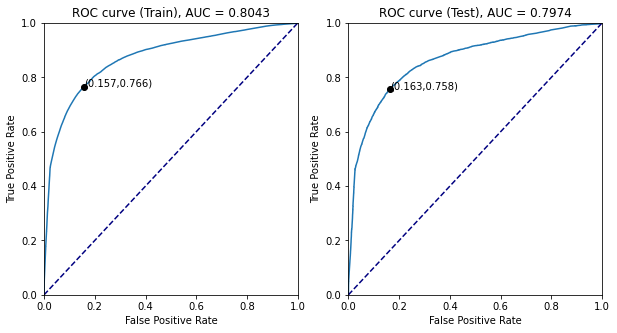

Train Accuracy: 0.8294877494411641 
Train AUC: 0.8042208706482922 
Train Confusion Matrix:
[[103827  17993]
 [  9239  28648]]
Test Accuracy: 0.8217054263565892 
Test AUC: 0.7941483021080068 
Test Confusion Matrix:
[[16660  3019]
 [ 1581  4540]]


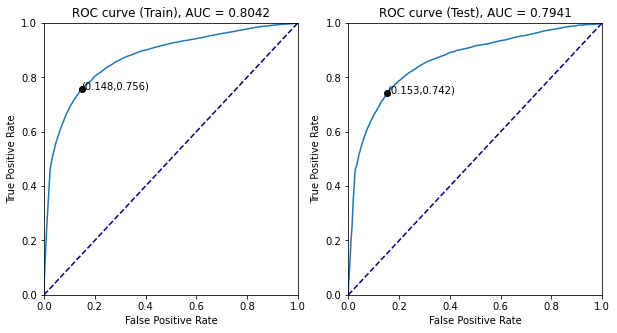

0.5389134092929122

In [ ]:
plot_ROC(y_train, cat_train_proba_, y_test, cat_test_proba_)
plot_ROC(y_train, cat_train_proba, y_test, cat_test_proba)

In [273]:
shap.initjs()
shap_values = catboost.get_feature_importance(train_pool, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

# visualize the first prediction's explanation
shap.force_plot(expected_value, shap_values[0,:], X_train_.iloc[np.random.randint(len(X_test_)),:])

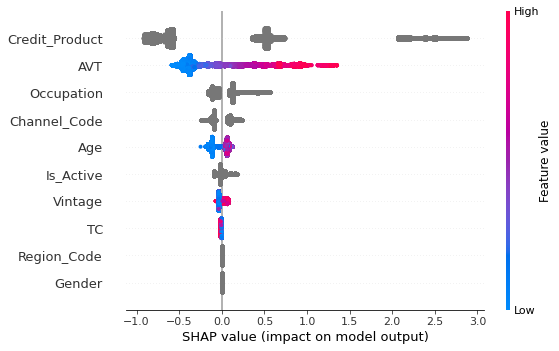

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_train_)
# the gray color comes from categorical features, that were not encoded outside catboost model
# but we can assume, that in Credit_Product gray dots on the right top side mean 'No', middle - 'NAN'
# AVT (age-vintage-targeted) shows that some combinations of age and vintage impacts the model significantly
# otherwise, inspite counting features are usually usefull for tree models,here TC has no impact on the prediction

In [ ]:
from catboost import cv

params = {"iterations": 200,
          "depth": 4,
          "loss_function": "Logloss",
          "verbose": False,
          "roc_file": "roc-file",
          }

scores = cv(train_pool,
            params,
            fold_count=3,
            plot="False")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.3381628255
bestIteration = 199

Training on fold [1/3]

bestTest = 0.3388647816
bestIteration = 199

Training on fold [2/3]

bestTest = 0.3407468632
bestIteration = 199



In [ ]:
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-Logloss-mean'].min()
    best_iter = cv_data['test-Logloss-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-Logloss-std'][best_iter],
        best_iter)
    )

params = {
    'loss_function': 'Logloss',
    'iterations': 200,
    'custom_loss': 'F1',
    'learning_rate': 0.1,
}

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=123)
cv_data = cv(
    params = params,
    pool = train_pool,
    verbose = False,
    folds = stratified_shuffle_split,
    plot = True
)

print_cv_summary(cv_data)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.3367934306
bestIteration = 198

Training on fold [1/5]

bestTest = 0.3340604078
bestIteration = 177

Training on fold [2/5]

bestTest = 0.3365113606
bestIteration = 198

Training on fold [3/5]

bestTest = 0.334931512
bestIteration = 199

Training on fold [4/5]

bestTest = 0.3382685246
bestIteration = 199

Best validation Logloss score : 0.3361±0.0016 on step 199


In [ ]:
cv_data.mean()

iterations            99.500000
test-Logloss-mean      0.343941
test-Logloss-std       0.001573
train-Logloss-mean     0.341416
train-Logloss-std      0.000566
test-F1-mean           0.661632
test-F1-std            0.003042
train-F1-mean          0.665190
train-F1-std           0.001933
dtype: float64